In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator

***

In [31]:
hierarchy = pd.read_parquet("../input/hierarchy_raw.parquet")

In [32]:
infile = open("../input/encoders.pkl", "rb")
encoders = pickle.load(infile)
infile.close()

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***

In [13]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

In [14]:
weights_level12 = pd.read_parquet("../input/weights_level12.parquet")
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level12 = compute_scaling(scaling_input, agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)

In [16]:
data_valid = data.query("'2016-04-25' <= ds <= '2016-05-22'")
submission = pd.read_csv("../output/lgbm_bottom_v131.csv.gz")

Timestamp('2016-05-22 00:00:00')

In [79]:
date_mapping1 = {f"F{i}": pd.to_datetime("2016-04-24")+pd.DateOffset(days=i) for i in range(1,29)}

forecast_level12_valid = (
    submission
    .loc[:30489, :]
    #.assign(id = lambda x: x.id.map(lambda x: x.replace("_validation","")))
    #.rename(date_mapping1, axis=1)
    .melt(id_vars="id", value_vars=[f"F{i}" for i in range(1,29)], var_name="ds", value_name="ypred")
    .assign(ds = lambda x: x.ds.map(date_mapping1))
)
forecast_level12_valid["id"] = forecast_level12_valid.id.apply(lambda x: x.replace("_validation",""))
forecast_level12_valid = pd.merge(forecast_level12_valid, hierarchy, how="left", on="id")

forecast_level12_valid["id"] = encoders["id"].transform(forecast_level12_valid["id"])
forecast_level12_valid["item_id"] = encoders["item"].transform(forecast_level12_valid["item_id"])
forecast_level12_valid["dept_id"] = encoders["dept"].transform(forecast_level12_valid["dept_id"])
forecast_level12_valid["cat_id"] = encoders["cat"].transform(forecast_level12_valid["cat_id"])
forecast_level12_valid["store_id"] = encoders["store"].transform(forecast_level12_valid["store_id"])
forecast_level12_valid["state_id"] = encoders["state"].transform(forecast_level12_valid["state_id"])

forecast_level12_valid = pd.merge(data_valid.loc[:, ["ts_id","ds"]], 
                            forecast_level12_valid, 
                            how="left", left_on=["ts_id","ds"], right_on=["id","ds"])

forecast_level12_valid

,ts_id,ds,id,ypred,item_id,dept_id,cat_id,store_id,state_id
0,1,2016-04-25,1,0.770518,1,1,1,1,1
1,1,2016-04-26,1,0.706685,1,1,1,1,1
2,1,2016-04-27,1,0.698131,1,1,1,1,1
3,1,2016-04-28,1,0.716536,1,1,1,1,1
4,1,2016-04-29,1,0.966544,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
853715,30490,2016-05-18,30490,2.109581,3049,7,3,10,3
853716,30490,2016-05-19,30490,2.117330,3049,7,3,10,3
853717,30490,2016-05-20,30490,2.497594,3049,7,3,10,3
853718,30490,2016-05-21,30490,2.702837,3049,7,3,10,3


In [80]:
import numpy as np
import pandas as pd

ts_id_columns_by_level = {
    1: [],
    2: ["state_id"],
    3: ["store_id"],
    4: ["cat_id"],
    5: ["dept_id"],
    6: ["state_id", "cat_id"],
    7: ["state_id", "dept_id"],
    8: ["store_id", "cat_id"],
    9: ["store_id", "dept_id"],
    10: ["item_id"],
    11: ["item_id", "state_id"],
    12: ["item_id", "store_id"]
}

scales_by_level = {
    1: pd.read_parquet("../input/scales_level1.parquet"),
    2: pd.read_parquet("../input/scales_level2.parquet"),
    3: pd.read_parquet("../input/scales_level3.parquet"),
    4: pd.read_parquet("../input/scales_level4.parquet"),
    5: pd.read_parquet("../input/scales_level5.parquet"),
    6: pd.read_parquet("../input/scales_level6.parquet"),
    7: pd.read_parquet("../input/scales_level7.parquet"),
    8: pd.read_parquet("../input/scales_level8.parquet"),
    9: pd.read_parquet("../input/scales_level9.parquet"),
    10: pd.read_parquet("../input/scales_level10.parquet"),
    11: pd.read_parquet("../input/scales_level11.parquet"),
    12: pd.read_parquet("../input/scales_level12.parquet"),
}

weights_by_level = {
    1: None,
    2: pd.read_parquet("../input/weights_level2.parquet"),
    3: pd.read_parquet("../input/weights_level3.parquet"),
    4: pd.read_parquet("../input/weights_level4.parquet"),
    5: pd.read_parquet("../input/weights_level5.parquet"),
    6: pd.read_parquet("../input/weights_level6.parquet"),
    7: pd.read_parquet("../input/weights_level7.parquet"),
    8: pd.read_parquet("../input/weights_level8.parquet"),
    9: pd.read_parquet("../input/weights_level9.parquet"),
    10: pd.read_parquet("../input/weights_level10.parquet"),
    11: pd.read_parquet("../input/weights_level11.parquet"),
    12: pd.read_parquet("../input/weights_level12.parquet")
}

class _WRMSSEEvaluator(object):
    def __init__(self, valid_dataframe, weights_dataframe, scales_dataframe, ts_uid_columns):
        self.valid_dataframe = valid_dataframe
        self.weights_dataframe = weights_dataframe
        self.scales_dataframe = scales_dataframe
        self.ts_uid_columns = ts_uid_columns
    
    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        valid_dataframe["ypred"] = predictions
        valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        return (valid_dataframe
                .groupby(self.ts_uid_columns)["sq_error"]
                .mean()
                .reset_index(name="mse")
                .merge(self.scales_dataframe, how="left", on=self.ts_uid_columns)
                .merge(self.weights_dataframe, how="left", on=self.ts_uid_columns)
                .assign(weight = lambda x: x.weight/x.weight.sum())
                .eval("weight * (sqrt(mse)/s)")
                .sum())
    
    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "wrmsse", metric, False
    
    
class WRMSSEEvaluatorL12(object):
    def __init__(self, valid_dataframe, weights_dataframe=None, scales_dataframe=None):
        self.valid_dataframe = valid_dataframe
        self.weights_dataframe = weights_by_level[12] if weights_dataframe is None else weights_dataframe
        self.scales_dataframe = scales_by_level[12] if scales_dataframe is None else scales_dataframe
        self.ts_uid_columns = ["item_id","store_id"]
    
    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        valid_dataframe["ypred"] = predictions
        valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        return (valid_dataframe
                .groupby(self.ts_uid_columns)["sq_error"]
                .mean()
                .reset_index(name="mse")
                .merge(self.scales_dataframe, how="left", on=self.ts_uid_columns)
                .merge(self.weights_dataframe, how="left", on=self.ts_uid_columns)
                .assign(weight = lambda x: x.weight/x.weight.sum())
                .eval("weight * (sqrt(mse)/s)")
                .sum())
    
    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "wrmsseL12", metric, False
    

class WRMSSEEvaluator(object):
    def __init__(self, valid_dataframe):
        self.valid_dataframe = valid_dataframe
    
    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        valid_dataframe["ypred"] = predictions
        errors_by_level = dict()
        
        # computation for level1
        scales = scales_by_level[1]
        mse = (valid_dataframe
               .groupby(["ds"])[["y","ypred"]]
               .sum()
               .reset_index()
               .eval("(y-ypred)**2")
               .mean())
        errors_by_level["root"] = np.sqrt(mse)/scales.s[0]
        
        # computation for levels 2 to 12
        for level in range(2,13):
            ts_id_columns = ts_id_columns_by_level[level]
            scales_dataframe = scales_by_level[level]
            weights_dataframe = weights_by_level[level]
            error = (valid_dataframe
                     .groupby(["ds"]+ts_id_columns)[["y","ypred"]]
                     .sum()
                     .reset_index()
                     .assign(sq_error = lambda x: x.eval("(y-ypred)**2"))
                     .groupby(ts_id_columns)["sq_error"]
                     .mean()
                     .reset_index(name="mse")
                     .merge(scales_dataframe, how="left", on=ts_id_columns)
                     .merge(weights_dataframe, how="left", on=ts_id_columns)
                     .assign(weight = lambda x: x.weight/x.weight.sum())
                     .eval("weight * (sqrt(mse)/s)")
                     .sum())
            errors_by_level[tuple(ts_id_columns)] = error
            
        self.errors_by_level = errors_by_level
        return np.mean(list(errors_by_level.values()))
    
    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "wrmsse", metric, False
    

class Evaluator(object):
    def __init__(self, valid_dataframe):
        self.eval1 = WRMSSEEvaluatorL12(valid_dataframe)
        self.eval2 = WRMSSEEvaluator(valid_dataframe)
    
    def evaluate(self, ypred, dtrain):
        return [self.eval1.evaluate(ypred, dtrain), self.eval2.evaluate(ypred, dtrain)]
        

In [81]:
evaluator = WRMSSEEvaluator(data_valid)

In [82]:
evaluator._evaluate(forecast_level12_valid.ypred.values)

0.4736692041983352

In [83]:
evaluator.errors_by_level

{'root': 0.1725570870660434,
 ('state_id',): 0.28492247182617136,
 ('store_id',): 0.37563338384238065,
 ('cat_id',): 0.2424238271904387,
 ('dept_id',): 0.3686085315068437,
 ('state_id', 'cat_id'): 0.35227160300701515,
 ('state_id', 'dept_id'): 0.4617431875833868,
 ('store_id', 'cat_id'): 0.44752726067214443,
 ('store_id', 'dept_id'): 0.5514476987259705,
 ('item_id',): 0.7948588643073765,
 ('item_id', 'state_id'): 0.8115429746485856,
 ('item_id', 'store_id'): 0.8204935600036647}

***
### level 1

In [2]:
forecast_level1 = (pd.read_csv("../output/forecast_level1-v2.csv", parse_dates=["ds"])
                   .rename({"ds":"fcst_date"}, axis=1))
forecast_level1.head()

,fcst_date,_internal_ts_uid,y_pred
0,2016-04-25,0,38015.395094
1,2016-04-26,0,35312.115645
2,2016-04-27,0,34393.566730
3,2016-04-28,0,34552.717141
4,2016-04-29,0,40075.140631


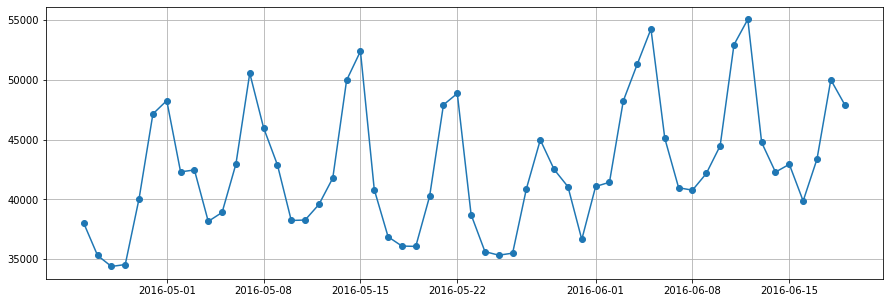

In [3]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast_level1.fcst_date, forecast_level1.y_pred, "o-")
plt.grid()
plt.show()

***
### level 2

In [4]:
forecast_level2 = (pd.read_csv("../output/forecast_level2-v2.csv", parse_dates=["ds"])
                   .rename({"ds":"fcst_date"}, axis=1))
forecast_level2.head()

,fcst_date,state_id,y_pred
0,2016-04-25,1,16786.189395
1,2016-04-26,1,15536.477508
2,2016-04-27,1,15034.834876
3,2016-04-28,1,15101.960522
4,2016-04-29,1,17131.933899


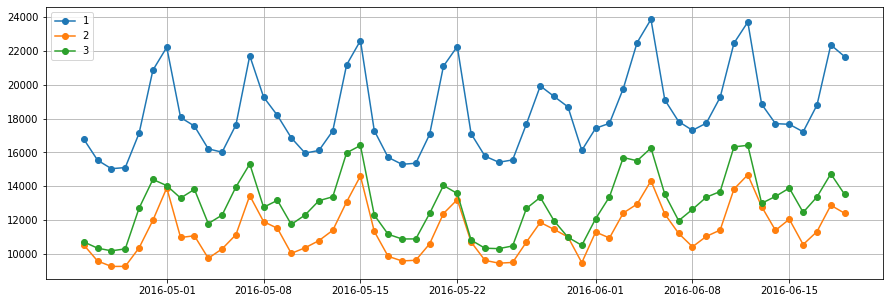

In [5]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast_level2.query("state_id == 1").fcst_date, forecast_level2.query("state_id == 1").y_pred, "o-", label="1")
plt.plot_date(forecast_level2.query("state_id == 2").fcst_date, forecast_level2.query("state_id == 2").y_pred, "o-", label="2")
plt.plot_date(forecast_level2.query("state_id == 3").fcst_date, forecast_level2.query("state_id == 3").y_pred, "o-", label="3")
plt.grid()
plt.legend(loc="best")
plt.show()

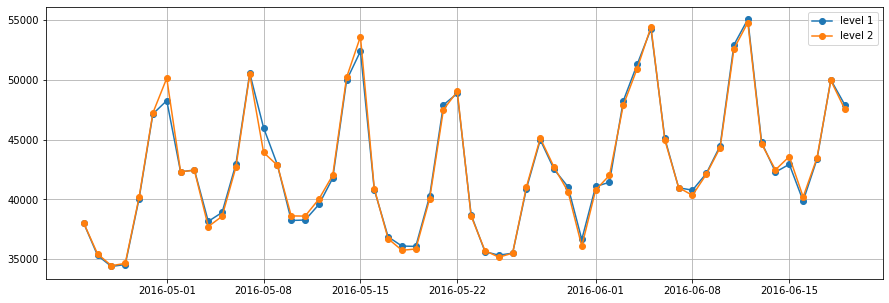

In [6]:
fcst2 = forecast_level2.groupby(["fcst_date"])["y_pred"].sum().reset_index()

plt.figure(figsize=(15,5))
plt.plot_date(forecast_level1.fcst_date, forecast_level1.y_pred, "o-", label="level 1")
plt.plot_date(fcst2.fcst_date, fcst2.y_pred, "o-", label="level 2")
plt.grid()
plt.legend(loc="best")
plt.show()

***
### level 3

In [7]:
forecast_level3 = (pd.read_csv("../output/forecast_level3-v2.csv", parse_dates=["ds"])
                   .rename({"ds":"fcst_date"}, axis=1))
forecast_level3.head()

,fcst_date,store_id,y_pred
0,2016-04-25,1,4070.675888
1,2016-04-26,1,3661.844311
2,2016-04-27,1,3541.711445
3,2016-04-28,1,3593.711243
4,2016-04-29,1,4404.226587


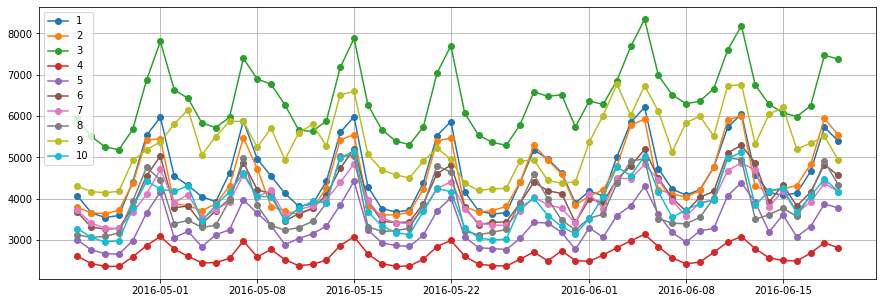

In [8]:
plt.figure(figsize=(15,5))
for store_nbr in np.sort(forecast_level3.store_id.unique()):
    plt.plot_date(forecast_level3.query("store_id == @store_nbr").fcst_date, forecast_level3.query("store_id == @store_nbr").y_pred, "o-", label=f"{store_nbr}")
plt.grid()
plt.legend(loc="best")
plt.show()

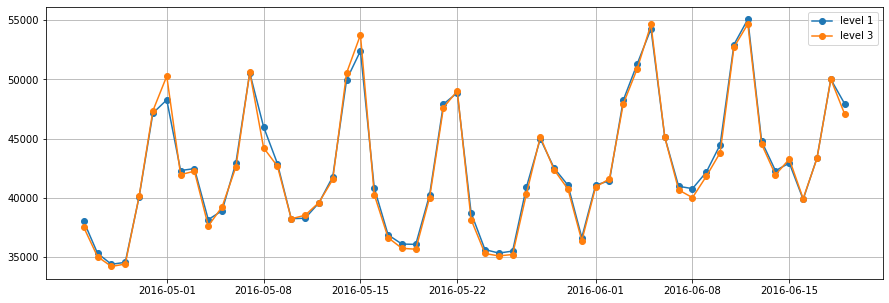

In [9]:
fcst3 = forecast_level3.groupby(["fcst_date"])["y_pred"].sum().reset_index()

plt.figure(figsize=(15,5))
plt.plot_date(forecast_level1.fcst_date, forecast_level1.y_pred, "o-", label="level 1")
plt.plot_date(fcst3.fcst_date, fcst3.y_pred, "o-", label="level 3")
plt.grid()
plt.legend(loc="best")
plt.show()

***

In [10]:
forecast_level12 = pd.read_csv("../output/lgbm_bottom_v106.csv.gz")

date_mapping1 = {f"F{i}": pd.to_datetime("2016-04-24")+pd.DateOffset(days=i) for i in range(1,29)}
date_mapping2 = {f"F{i}": pd.to_datetime("2016-05-22")+pd.DateOffset(days=i) for i in range(1,29)}

forecast_level12_valid = (
    forecast_level12
    .loc[:30489, :]
    .assign(id = lambda x: x.id.map(lambda x: x.replace("_validation","")))
    .rename(date_mapping1, axis=1)
    .set_index("id")
    .transpose()
)

forecast_level12_eval = (
    forecast_level12
    .loc[30490:, :]
    .assign(id = lambda x: x.id.map(lambda x: x.replace("_evaluation","")))
    .rename(date_mapping2, axis=1)
    .set_index("id")
    .transpose()
)

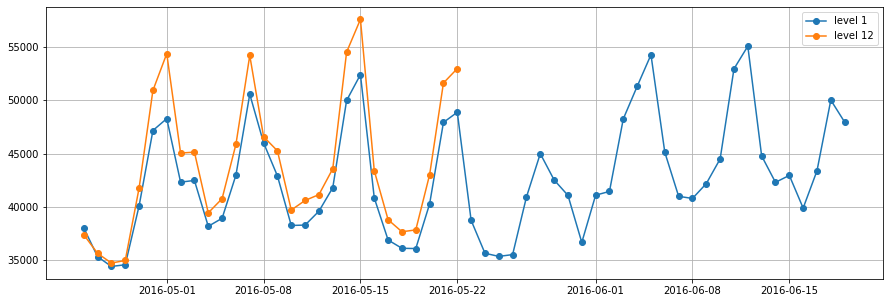

In [11]:
plt.figure(figsize=(15,5))
plt.plot_date(forecast_level1.query("fcst_date <= '2020-05-22'").fcst_date, forecast_level1.query("fcst_date <= '2020-05-22'").y_pred, "o-", label="level 1")
plt.plot_date(forecast_level12_valid.index, forecast_level12_valid.values.sum(axis=1), "o-", label="level 12")
plt.grid()
plt.legend(loc="best")
plt.show()

***

In [3]:
# LB: 0.56029
date_mapping = {f"F{i}": pd.to_datetime("2016-04-24")+pd.DateOffset(days=i) for i in range(1,29)}

#filename = "../output/kaggle_submissions/m5-first-public-notebook-under-0-50.csv"
filename = "../output/lgbm_bottom_v40.csv.gz"
forecast_level12 = (pd.read_csv(filename)
                    .loc[0:30489, :]
                    .pipe(pd.melt, id_vars=["id"], value_vars=[f"F{i}" for i in range(1,29)], var_name="F", value_name="q")
                    .assign(fcst_date = lambda x: x.F.map(date_mapping))
                    .groupby("fcst_date")["q"]
                    .sum()
                    .reset_index()
                   )
forecast_level12.head()

,fcst_date,q
0,2016-04-25,37778.911442
1,2016-04-26,35358.463356
2,2016-04-27,34713.182600
3,2016-04-28,34751.197862
4,2016-04-29,40802.765371


***

In [3]:
date_mapping = {f"F{i}": pd.to_datetime("2016-04-24")+pd.DateOffset(days=i) for i in range(1,29)}

#filename = "../output/kaggle_submissions/m5-first-public-notebook-under-0-50.csv"
filename = "../output/lgbm_bottom_v38.csv.gz"
forecast_level12_base = (pd.read_csv(filename)
                    .loc[0:30489, :]
                    .pipe(pd.melt, id_vars=["id"], value_vars=[f"F{i}" for i in range(1,29)], var_name="F", value_name="q")
                    .assign(fcst_date = lambda x: x.F.map(date_mapping))
                    .groupby("fcst_date")["q"]
                    .sum()
                    .reset_index()
                   )

filename = "../output/lgbm_bottom_v41.csv.gz"
forecast_level12_hts = (pd.read_csv(filename)
                    .loc[0:30489, :]
                    .pipe(pd.melt, id_vars=["id"], value_vars=[f"F{i}" for i in range(1,29)], var_name="F", value_name="q")
                    .assign(fcst_date = lambda x: x.F.map(date_mapping))
                    .groupby("fcst_date")["q"]
                    .sum()
                    .reset_index()
                   )

In [4]:
mrg = (forecast_level1
       .merge(forecast_level12_base, how="inner", on="fcst_date")
       .merge(forecast_level12_hts, how="inner", on="fcst_date")
      )
mrg

,fcst_date,y_pred,q_x,q_y
0,2016-04-25,37819.654281,40922.201497,39581.025232
1,2016-04-26,35308.574794,37777.649251,36656.539335
2,2016-04-27,34276.951094,36750.896734,35656.373492
3,2016-04-28,34244.012754,37076.625277,35867.867105
4,2016-04-29,40125.732164,42485.798053,41313.251673
5,2016-04-30,46214.225551,51351.630119,49740.020733
6,2016-05-01,47453.313465,55220.289343,52894.749457
7,2016-05-02,42584.215194,45990.768810,44346.291278
8,2016-05-03,42203.286395,43858.829824,43073.394693
9,2016-05-04,37912.028116,40038.811375,39048.547360


/home/turing/miniconda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


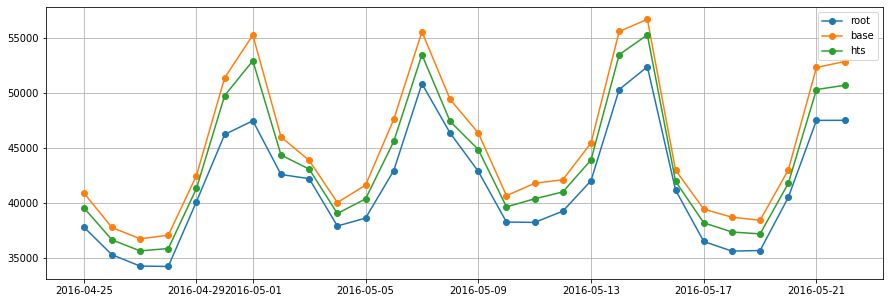

In [5]:
plt.figure(figsize=(15,5))
plt.plot_date(mrg.fcst_date, mrg.y_pred, "o-", label="root")
plt.plot_date(mrg.fcst_date, mrg.q_x, "o-", label="base")
plt.plot_date(mrg.fcst_date, mrg.q_y, "o-", label="hts")
plt.grid()
plt.legend(loc="best")
plt.show()

***

In [4]:
kaggle_submissions = dict()

for fname in os.listdir("../output/kaggle_submissions"):
    sub = (pd.read_csv(f"../output/kaggle_submissions/{fname}")
           .loc[0:30489, :]
           .pipe(pd.melt, id_vars=["id"], value_vars=[f"F{i}" for i in range(1,29)], var_name="F", value_name="q")
           .assign(fcst_date = lambda x: x.F.map(date_mapping))
           .groupby("fcst_date")["q"]
           .sum()
           .reset_index()
           )
    kaggle_submissions[fname] = sub

submission: m5-forecaster-v2.csv


/home/turing/miniconda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


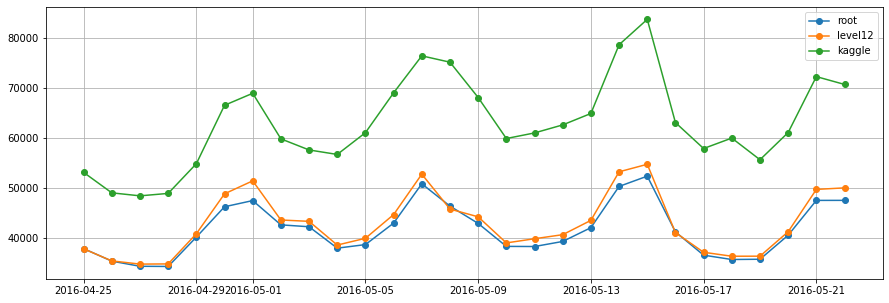

submission: m5-accuracy-tweedie-is-back.csv


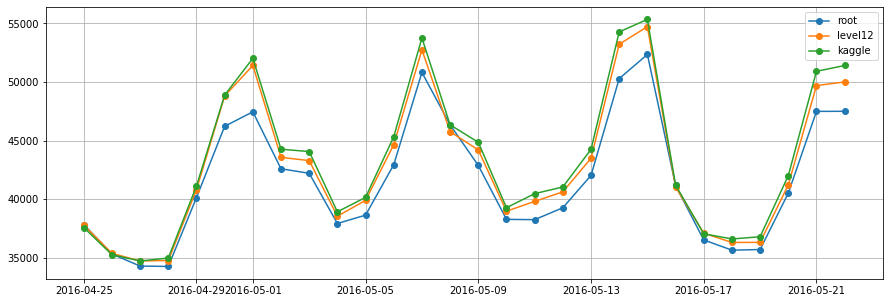

submission: fnu050-num-leaves-76.csv


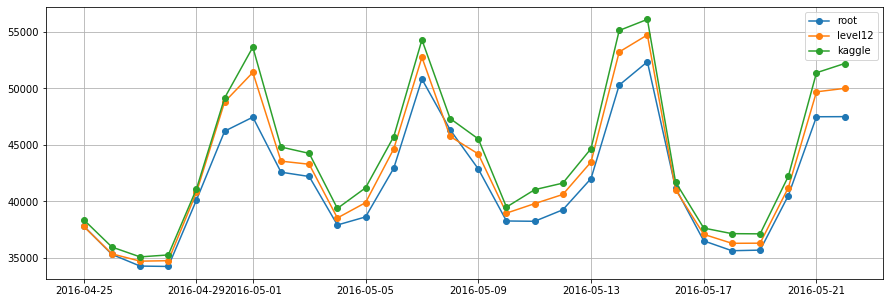

submission: m5-first-public-notebook-under-0-50.csv


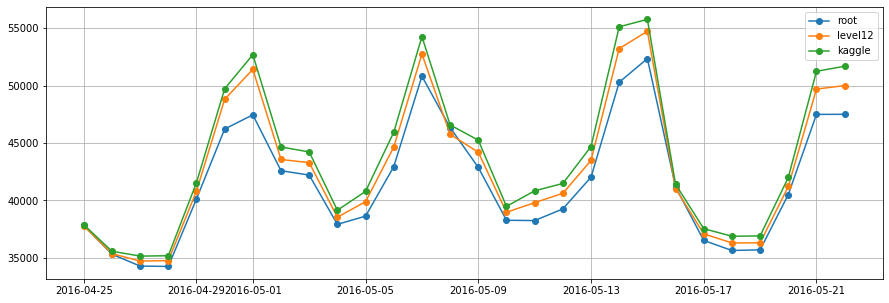

submission: m5-accuracy-poisson-tweedie.csv


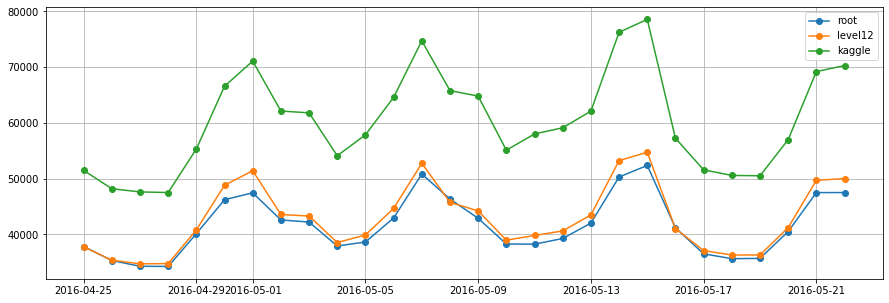

submission: m5-forecast-v2-python.csv


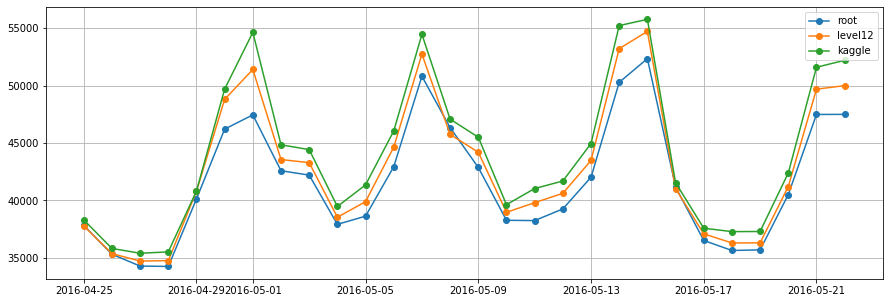

In [5]:
for key,forecast in kaggle_submissions.items():
    mrg = (forecast_level1 
           .merge(forecast_level12, how="inner", on="fcst_date")
           .merge(forecast, how="inner", on="fcst_date"))
    
    print(f"submission: {key}")

    plt.figure(figsize=(15,5))
    plt.plot_date(mrg.fcst_date, mrg.y_pred, "o-", label="root")
    plt.plot_date(mrg.fcst_date, mrg.q_x, "o-", label="level12")
    plt.plot_date(mrg.fcst_date, mrg.q_y, "o-", label="kaggle")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

***